In [1]:
import numpy as np
import scipy.signal as spsig
import scipy.fftpack as spfft
import scipy.io.wavfile as spiow

import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Implementation de nos filtres

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = spsig.filtfilt(b, a, data)
    return y

def butter_highpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = butter(order, normal_cutoff, btype='highpass')
    return b, a

def butter_highpass_filter(data, cutoff_freq, nyq_freq, order=4):
    # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
    b, a = butter_highpass(cutoff_freq, nyq_freq, order=order)
    y = spsig.filtfilt(b, a, data)
    return y

44100
(403139,)
(403139,)


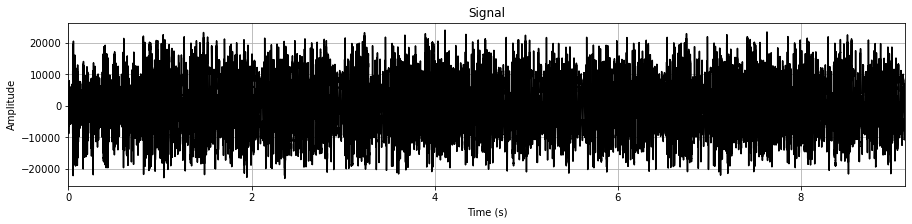

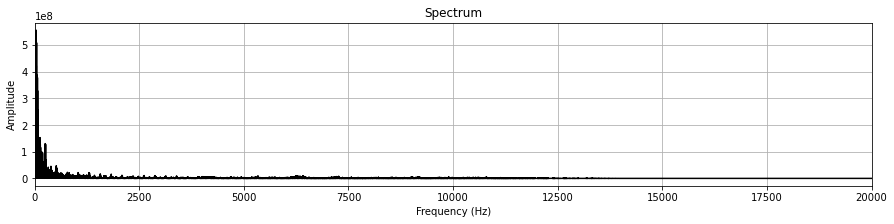

In [3]:
# Ouverture, interprétation et affichage du signal d'entrée et de son spectre

PathSounds = 'sounds/'
FileName = 'extrait_techno_mono.wav'
sr,x=spiow.read(PathSounds+FileName)


N = len(x)
dur = N/sr
t = np.arange(0,dur,1/sr)
print(sr)

#x = x[0:int(0.5*sr)] # Cut the signal if you want (faster computation when prototyping)
x = np.array(x,dtype='int64') # You'll probably need it to perform type conversion (e.g. when **2 is returning negative values...)
Nfft = len(x) # Number of points on which the FFT is computed
X = spfft.fft(x,N) # spectrum

#X = spfft.fft(x) # spectrum
f = np.arange(-sr/2,(sr/2),sr/Nfft) # associated frequency array
#f = spfft.rfftfreq(N, 1 / sr)
#X = X[0:int(len(X)/2)]
#f = f[int(len(f)/2):]
print(X.shape)
print(f.shape)

fig=plt.figure(figsize=(15,3))
plt.plot(t,x,'k')
plt.title('Signal')
plt.xlabel('Time (s)')
plt.grid()
plt.ylabel('Amplitude')
plt.xlim([0,dur])


fig=plt.figure(figsize=(15,3))
plt.plot(f,np.abs(spfft.fftshift(X)),'k')
plt.title('Spectrum')
plt.grid()
plt.xlim([0,20000])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')


x = x/np.amax(x)

Text(0.5, 0, 'Time (s)')

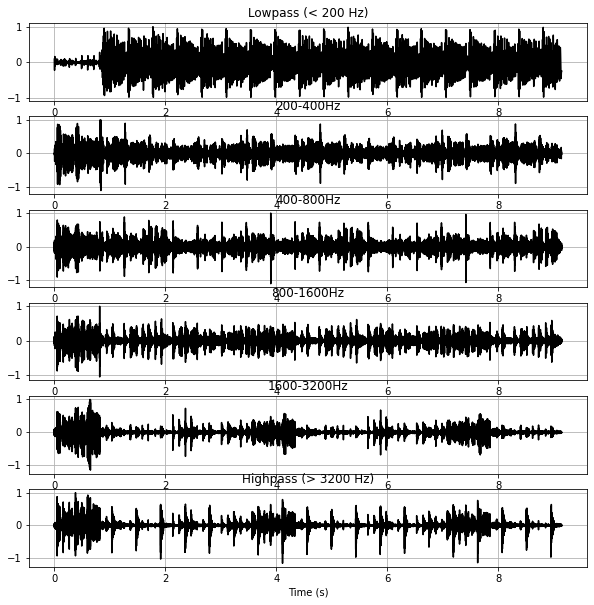

In [4]:
#Premiere etape : on filtre le signal sur 6 plages de fréquences différentes
# On crée un fichier wav pour chaque signal filtré, afin de se rentre bien compte du filtrage

DirOut = 'output/'

#Lowpass (<200Hz)
xFilt1 = butter_lowpass_filter(x, 200, sr, order=4)
xFilt1 = xFilt1/np.amax(xFilt1)
spiow.write(DirOut + 'lowpass.wav', sr, xFilt1)

# 200-400
xFilt2 = butter_bandpass_filter(x, 200, 400, sr, order=4)
xFilt2 = xFilt2/np.amax(xFilt2)
spiow.write(DirOut + '200_400.wav', sr, xFilt2)

# 400-800
xFilt3 = butter_bandpass_filter(x, 400, 800, sr, order=4)
xFilt3 = xFilt3/np.amax(xFilt3)
spiow.write(DirOut + '400_800.wav', sr, xFilt3)

# 800-1600
xFilt4 = butter_bandpass_filter(x, 800, 1600, sr, order=4)
xFilt4 = xFilt4/np.amax(xFilt4)
spiow.write(DirOut + '800_1600.wav', sr, xFilt4)

# 1600-3200
xFilt5 = butter_bandpass_filter(x, 1600, 3200, sr, order=4)
xFilt5 = xFilt5/np.amax(xFilt5)
spiow.write(DirOut + '1600_3200.wav', sr, xFilt5)

# Highpass (> 3200Hz)
xFilt6 = butter_highpass_filter(x, 3200, sr, order=4)
xFilt6 = xFilt6/np.amax(xFilt6)
spiow.write(DirOut + 'highpass.wav', sr, xFilt6)




fig, axs = plt.subplots(6, figsize=(10,10))
axs[0].plot(t, xFilt1,'k')
axs[0].set_title("Lowpass (< 200 Hz)")
axs[0].grid()
axs[1].plot(t, xFilt2,'k')
axs[1].set_title("200-400Hz")
axs[1].grid()
axs[2].plot(t, xFilt3,'k')
axs[2].set_title("400-800Hz")
axs[2].grid()
axs[3].plot(t, xFilt4,'k')
axs[3].set_title("800-1600Hz")
axs[3].grid()
axs[4].plot(t, xFilt5,'k')
axs[4].set_title("1600-3200Hz")
axs[4].grid()
axs[5].plot(t, xFilt6,'k')
axs[5].set_title("Highpass (> 3200 Hz)")
axs[5].grid()
plt.xlabel('Time (s)')

In [5]:
# Fonction calculant la moyenne mobile d'un signal, pour une fenêtre de largeur M

def AverageFilter(x,M):
    
    xavg = np.zeros(len(x))
    
    for ind in range(M,len(x)-M):
        start_ind = int(ind-M/2)
        #start_ind = ind-math.floor(M/2) # use int instead of math.floor should work too
        end_ind = start_ind+M #        end_ind = ind+M/2-1
        xavg[ind] = np.mean(x[start_ind:end_ind])
        
    # What value on the left?
    for ind in range(M):
        xavg[ind] = xavg[M]
    
    # What value on the right?
    for ind in range(len(x)-M,len(x)):
        xavg[ind] = xavg[len(x)-M-1]
    
    return xavg

In [6]:
# On récupère les enveloppes

n_pts_AvgFilt = 2500
env1 = AverageFilter(xFilt1**2,n_pts_AvgFilt)
env2 = AverageFilter(xFilt2**2,n_pts_AvgFilt)
env3 = AverageFilter(xFilt3**2,n_pts_AvgFilt)
env4 = AverageFilter(xFilt4**2,n_pts_AvgFilt)
env5 = AverageFilter(xFilt5**2,n_pts_AvgFilt)
env6 = AverageFilter(xFilt6**2,n_pts_AvgFilt)

Text(0.5, 0, 'Time (s)')

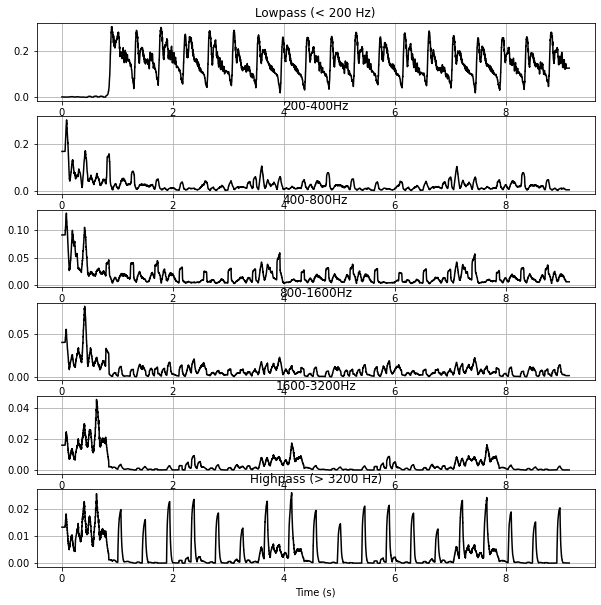

In [7]:
#Et on les affiche

fig, axs = plt.subplots(6, figsize=(10,10))
axs[0].plot(t, env1,'k')
axs[0].set_title("Lowpass (< 200 Hz)")
axs[0].grid()
axs[1].plot(t, env2,'k')
axs[1].set_title("200-400Hz")
axs[1].grid()
axs[2].plot(t, env3,'k')
axs[2].set_title("400-800Hz")
axs[2].grid()
axs[3].plot(t, env4,'k')
axs[3].set_title("800-1600Hz")
axs[3].grid()
axs[4].plot(t, env5,'k')
axs[4].set_title("1600-3200Hz")
axs[4].grid()
axs[5].plot(t, env6,'k')
axs[5].set_title("Highpass (> 3200 Hz)")
axs[5].grid()
plt.xlabel('Time (s)')

In [8]:
# fonction demi-Hanning de fenêtre de largeur window_len

def half_hanning(x, window_len):
    s = np.r_[2*x[0] - x[window_len:1:-1], x, 2*x[-1] - x[-1:-window_len:-1]]
    w = np.hanning(window_len)
    y = np.convolve(w/w.sum(), s, mode='same')
    return y[window_len-1:-window_len+1]

In [9]:
rect1 = np.abs(half_hanning(env1**3,200))
rect2 = np.abs(half_hanning(env2**3,200))
rect3 = np.abs(half_hanning(env3**3,200))
rect4 = np.abs(half_hanning(env4**3,200))
rect5 = np.abs(half_hanning(env5**3,200))
rect6 = np.abs(half_hanning(env6**3,200))

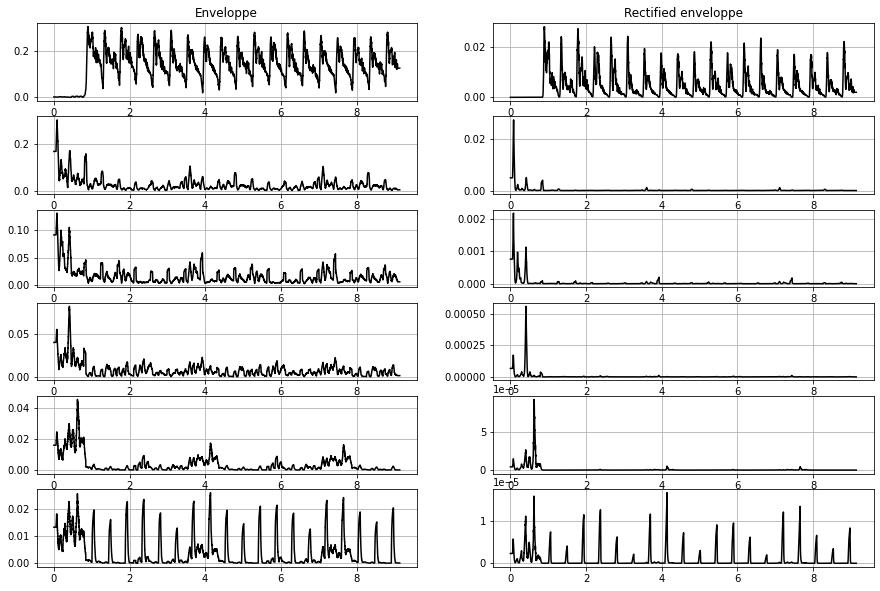

In [11]:
# Affichage des enveloppes extraites et des enveloppes rectifiées

tabFilt = [xFilt1, xFilt2, xFilt3, xFilt4, xFilt5, xFilt6]
tabEnv = [env1, env2, env3, env4, env5, env6]
tabRect = [rect1, rect2, rect3, rect4, rect5, rect6]
fig, axs = plt.subplots(6,2, figsize=(15,10))
axs[0][0].set_title('Enveloppe')
axs[0][1].set_title('Rectified enveloppe')
for i in range(0,6):
    axs[i][0].plot(t, tabEnv[i],'k')
    axs[i][1].plot(t, tabRect[i],'k')
    axs[i][0].grid()
    axs[i][1].grid()

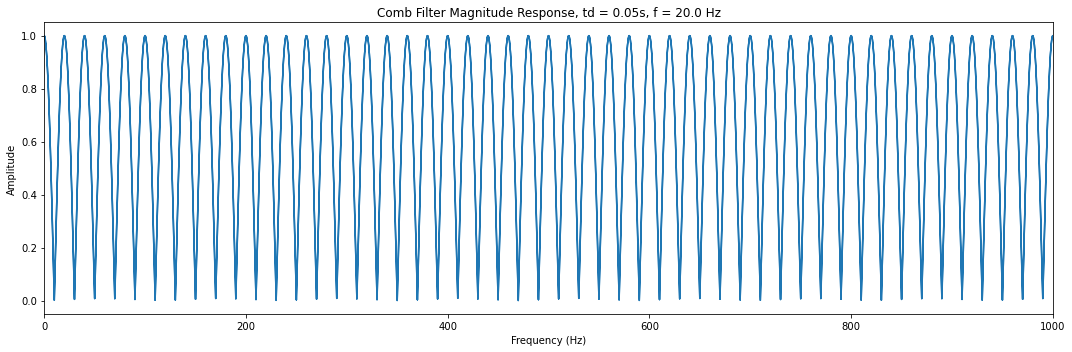

In [12]:
#Maintenant qu'on a l'enveloppe on peut déterminer le tempo

def comb_filter(td):
    #td = 0.06
    f0 = 1/td
    #print("Delay of the comb filter : " + str(td))
    #print("Frequency of the comb filter : " + str(f0))
    #print("Estimated bpm of the track : " + str(f0*60))

    w = 2*(np.pi)*f

    gain = np.abs(np.cos((w*td/2)))
    return gain

# on analyse le tempo de 60 à 200 bpm
# donc de 60/60 et 200/60 = 1 à 3,4 Hz (battements par seconde)
# donc de 1 à 0.29 <=> 0.29 à 1s pour les delays des résonnateurs
# On va donc faire passer chaque enveloppe dans des filtres en peigne de delays allant de td = 0.29s à td = 1s 
# (td = delay time du resonnateur)
# On incrémentera td de 0.001 pour un minimum de précision sur le bpm
tdExample = 0.05
combExample = comb_filter(tdExample)

fig = plt.figure(figsize=(15,5))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Comb Filter Magnitude Response, td = ' + str(tdExample) + 's, f = ' + str(1/tdExample) + " Hz")
plt.plot(np.abs(f), combExample)
plt.xlim([0,1000])
plt.tight_layout()

Energie du signal : 10.170127493403827


Text(0.5, 1.0, 'Signal equivalent')

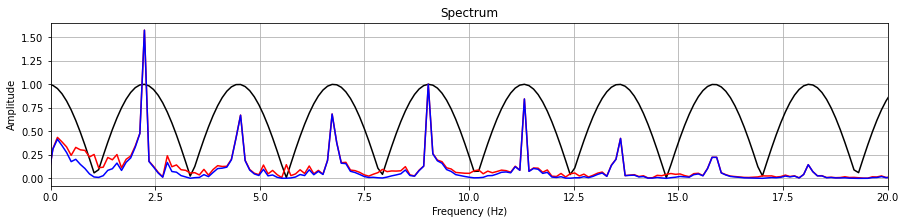

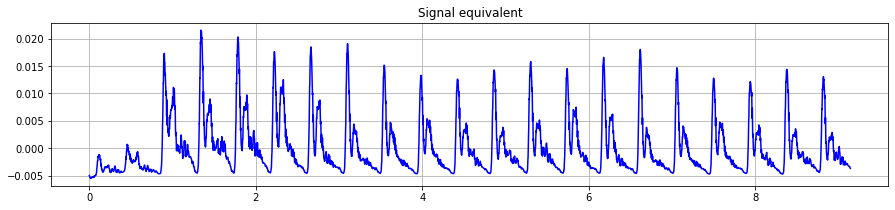

In [13]:
Xrect1 = spfft.fft(rect1,N) #spectre du low-pass filter (celui qui nous intéresse le plus)
Xrect2 = spfft.fft(rect2,N)
Xrect3 = spfft.fft(rect3,N)
Xrect4 = spfft.fft(rect4,N)
Xrect5 = spfft.fft(rect5,N)
Xrect6 = spfft.fft(rect6,N)
(Xrect1[0],Xrect2[0],Xrect3[0],Xrect4[0],Xrect5[0],Xrect6[0]) = (1,1,1,1,1,1)

tabXRect = [Xrect1, Xrect2, Xrect3, Xrect4, Xrect5, Xrect6]

#test du filtre en peigne
tTest = 0.440  #correspond a un bpm de 136.5
combT = comb_filter(tTest)
testT = np.abs(combT)*Xrect1
backTest = np.real(spfft.ifft(testT,N))
En = np.real(np.sum(backTest**2))

print("Energie du signal : " + str(En))

fig=plt.figure(figsize=(15,3))
plt.plot(f,np.abs(spfft.fftshift(combT)),'k')    #filtre en peigne en noir
plt.plot(f,np.abs(spfft.fftshift(Xrect1)/np.max(Xrect1)),'r')     #spectre en rouge
plt.plot(f,np.abs(spfft.fftshift(testT)/np.max(testT)),'b')     #spectre filtré avec le filtre en peigne
plt.title('Spectrum')
plt.grid()
plt.xlim([0,20])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

fig=plt.figure(figsize=(15,3))
plt.plot(t,backTest,'b')   #on recupere le signal en faisant une transformée de Fourrier inverse
plt.grid()
plt.title('Signal equivalent')

In [14]:
# On applique les filtres en peigne à chaque bande de fréquene
# Le processus est assez long en raison du nombre de filtres qu'on applique :
# environ 6*710 = 4260 filtrages + transformées inverses et calculs d'énergies

td = 0.29
energiesMax = []
bestTds = []
for XRect in tabXRect:
    bestTd = 0
    energieMax = 0
    while td <= 0.9:
        comb = comb_filter(td)
        test = np.abs(comb)*XRect
        sigTest = np.real(spfft.ifft(test,N))
        E = np.real(np.sum(sigTest**2))
        if E > energieMax:
            #print("Energie : " + str(E))
            energieMax = E
            bestTd = td
            #print("Td : " + str(td))
        td += 0.001
    bestTds.append(bestTd)
    energiesMax.append(energieMax)
    td = 0.29
    
    
print("Energies : " + str(energiesMax))
print("tds : " + str(bestTds))

Energies : [10.170127493410412, 0.4747349869757336, 0.005185130020389493, 0.00022959646222388071, 8.623210183732562e-06, 4.024169096559049e-06]
tds : [0.4400000000000001, 0.342, 0.342, 0.4030000000000001, 0.342, 0.4400000000000001]


In [15]:
energieMaxTot = max(energiesMax)
combTd = bestTds[energiesMax.index(energieMaxTot)]
combFrequency = 1/combTd
bpm = combFrequency*60
print("Biggest energy : " + str(energieMaxTot))
print("Matching td : " + str(combTd))
print("Associated frequency : " + str(combFrequency))
print("Estimated BPM : " + str(round(bpm,3)))

Biggest energy : 10.170127493410412
Matching td : 0.4400000000000001
Associated frequency : 2.272727272727272
Estimated BPM : 136.364
